# MARUTI.NS Stock Price Prediction with LSTM
This notebook demonstrates stock price prediction for MARUTI.NS using an LSTM model, following a modular and clean structure.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import plotly.graph_objects as go
from tensorflow.keras.utils import plot_model
import pymongo
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [2]:
# Data Fetching
ticker = 'MARUTI.NS'
start_date = '2019-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
print(f"End date: {end_date}") 
df = yf.download(ticker, start=start_date, end=end_date)
if df.empty:
    print("Failed to fetch data. Please check the ticker symbol and date range.")
else:
    print(f"Data fetched for {ticker} from {start_date} to {end_date}")

End date: 2025-05-16
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data fetched for MARUTI.NS from 2019-01-01 to 2025-05-16


In [3]:
# Fetch NIFTY and SENSEX data
nifty = yf.download("^NSEI", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'NIFTY_Close'})
sensex = yf.download("^BSESN", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'SENSEX_Close'})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Merge with main stock dataframe
df = df.merge(nifty, left_index=True, right_index=True, how='inner')
df = df.merge(sensex, left_index=True, right_index=True, how='inner')

In [5]:
print(df['Close'].head())
print(df['Close'].isnull().sum())

Ticker        MARUTI.NS
Date                   
2019-01-02  6882.405762
2019-01-03  6821.895020
2019-01-04  6850.824219
2019-01-07  6971.608398
2019-01-08  7044.952148
Ticker
MARUTI.NS    0
dtype: int64


In [6]:
# Plot Stock Price History
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df.index, y=df['Close'],
    mode='lines', name='Stock Prices',
    fill='tozeroy',
    line=dict(color='rgba(74,143,223,1)')
))
fig.update_layout(
    title='Stock Price History',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    width=900,
    legend=dict(x=0, y=1),
    plot_bgcolor='rgba(19,27,43,0.0)',
    paper_bgcolor='rgba(19,27,43,0.0)',
    font=dict(color='rgba(105,123,147,255)'),
    hovermode="closest",
    yaxis=dict(
        spikecolor="rgba(105,123,149,255)",
        spikedash="solid",
        spikethickness=-2,
        tickformat=',',
        tickprefix='₹',
        gridcolor="rgba(105,123,147,0.4)",
        zeroline=False
    ),
    xaxis=dict(
        spikecolor="rgba(105,123,147,255)",
        spikedash="solid",
        spikethickness=-2,
        gridcolor="rgba(105,123,147,0.4)"
    )
)
fig.update_xaxes(showline=False, linewidth=0, linecolor='rgba(105,123,147,255)')
fig.show()

In [7]:
print(df.head())

Price             Close         High          Low         Open    Volume  \
Ticker        MARUTI.NS    MARUTI.NS    MARUTI.NS    MARUTI.NS MARUTI.NS   
Date                                                                       
2019-01-02  6882.405762  7064.365155  6859.820534  7050.160668    891844   
2019-01-03  6821.895020  6960.199201  6804.518103  6893.911590    715168   
2019-01-04  6850.824219  6921.373172  6781.411809  6855.085565    774445   
2019-01-07  6971.608398  7014.174690  6912.849364  6922.319020    687845   
2019-01-08  7044.952148  7059.440540  6933.778455  6988.607683    516841   

Price        NIFTY_Close  SENSEX_Close  
Ticker             ^NSEI        ^BSESN  
Date                                    
2019-01-02  10792.500000  35891.519531  
2019-01-03  10672.250000  35513.710938  
2019-01-04  10727.349609  35695.101562  
2019-01-07  10771.799805  35850.160156  
2019-01-08  10802.150391  35980.929688  


In [8]:
model_save_path = "finbert_sentiment089"
tokenizer = AutoTokenizer.from_pretrained(model_save_path)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_save_path)


In [9]:

def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
        scores = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
        sentiment = int(scores.argmax())
    return sentiment  # 0=negative, 1=neutral, 2=positive (adjust as per your model)


In [10]:

# Get news for company ticker, NIFTY, and SENSEX from database and update sentiment if missing
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["stock_news"]
collection = db["moneyworks_company_news"]

tickers_to_fetch = [ticker, "^NSEI", "^BSESN"]

news_sentiment_daily_dict = {}

for tkr in tickers_to_fetch:
    # Only get news for the current ticker
    news_cursor = collection.find({"yahoo_ticker": tkr})
    # Update news documents with sentiment if missing, otherwise use existing sentiment
    for doc in news_cursor:
        if "sentiment" not in doc or doc["sentiment"] in ("", None):
            title = doc.get("title", "")
            if title:
                sentiment = get_sentiment(title)
                collection.update_one({"_id": doc["_id"]}, {"$set": {"sentiment": sentiment}})
        # If sentiment is present and not empty, do nothing (keep the value)
    # Re-query for aggregation (to include updated sentiments)
    news_cursor = collection.find({"yahoo_ticker": tkr, "sentiment": {"$exists": True}})
    news_df = pd.DataFrame(list(news_cursor))
    if not news_df.empty:
        news_df["date"] = pd.to_datetime(news_df["date"]).dt.date
        news_sentiment_daily = news_df.groupby("date")["sentiment"].mean()
    else:
        news_sentiment_daily = pd.Series(dtype=float)
    news_sentiment_daily_dict[tkr] = news_sentiment_daily

# Fix for MergeError: flatten MultiIndex columns before merging sentiment
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join([str(i) for i in col if i]) for col in df.columns.values]

df["date"] = df.index.date
df = df.copy()
df = df.merge(news_sentiment_daily_dict.get(ticker, pd.Series(dtype=float)).rename("news_sentiment_company"), left_on="date", right_index=True, how="left")
df = df.merge(news_sentiment_daily_dict.get("^NSEI", pd.Series(dtype=float)).rename("news_sentiment_nifty"), left_on="date", right_index=True, how="left")
df = df.merge(news_sentiment_daily_dict.get("^BSESN", pd.Series(dtype=float)).rename("news_sentiment_sensex"), left_on="date", right_index=True, how="left")

df["news_sentiment_company"] = df["news_sentiment_company"].fillna(0)
df["news_sentiment_nifty"] = df["news_sentiment_nifty"].fillna(0)
df["news_sentiment_sensex"] = df["news_sentiment_sensex"].fillna(0)

# After merging sentiment columns, check if news_df is empty for each ticker
for tkr in tickers_to_fetch:
    news_cursor = collection.find({"yahoo_ticker": tkr, "sentiment": {"$exists": True}})
    news_df = pd.DataFrame(list(news_cursor))
    if news_df.empty:
        print(f"Warning: No sentiment data found for {tkr}. All sentiment values will be zero.")
    else:
        print(f"Sentiment data found for {tkr}: {news_df.shape[0]} records.")

# Rename columns and drop 'date' column
df = df.rename(columns={
    'Close_MARUTI.NS': 'Close',
    'Open_MARUTI.NS': 'Open',
    'High_MARUTI.NS': 'High',
    'Low_MARUTI.NS': 'Low',
    'Volume_MARUTI.NS': 'Volume',
    'NIFTY_Close_^NSEI': 'NIFTY_Close',
    'SENSEX_Close_^BSESN': 'SENSEX_Close'
})
if 'date' in df.columns:
    df = df.drop(columns=['date'])


Sentiment data found for MARUTI.NS: 1429 records.
Sentiment data found for ^NSEI: 441 records.
Sentiment data found for ^BSESN: 19 records.


In [11]:
df.head()

,Close,High,Low,Open,Volume,NIFTY_Close,SENSEX_Close,news_sentiment_company,news_sentiment_nifty,news_sentiment_sensex
Date,,,,,,,,,,
2019-01-02,6882.405762,7064.365155,6859.820534,7050.160668,891844,10792.500000,35891.519531,0.0,0.0,0.0
2019-01-03,6821.895020,6960.199201,6804.518103,6893.911590,715168,10672.250000,35513.710938,0.0,0.0,0.0
2019-01-04,6850.824219,6921.373172,6781.411809,6855.085565,774445,10727.349609,35695.101562,0.0,0.0,0.0
2019-01-07,6971.608398,7014.174690,6912.849364,6922.319020,687845,10771.799805,35850.160156,0.0,0.0,0.0
2019-01-08,7044.952148,7059.440540,6933.778455,6988.607683,516841,10802.150391,35980.929688,2.0,0.0,0.0


In [12]:
# Select Necessary Columns
df = df[['Close', 'Open', 'High', 'Low', 'Volume', 'NIFTY_Close', 'SENSEX_Close',
         'news_sentiment_company', 'news_sentiment_nifty', 'news_sentiment_sensex']]

In [13]:
# Normalize Data Using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = scaler.fit_transform(df)
df_array = df_scaled.astype(np.float32)

In [14]:
# Create Sequences for Time Series Forecasting
def create_sequences(data, seq_length=20):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

In [15]:
# Define Look-Back Period
seq_length = 30
sequences = create_sequences(df_array, seq_length + 1)

In [16]:
# Split Data into Train (80%), Validation (10%), Test (10%)
def split_data(sequence):
    train_data, test_data = train_test_split(sequence, test_size=0.3, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)
    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(sequences)

In [17]:
# Separate Features (X) and Target (y)
X_train, y_train = train_data[:, :-1, :], train_data[:, -1, 0]
X_valid, y_valid = val_data[:, :-1, :], val_data[:, -1, 0]
X_test, y_test = test_data[:, :-1, :], test_data[:, -1, 0]

print(f"x_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"x_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (1073, 30, 10), y_train shape: (1073,)
x_valid shape: (230, 30, 10), y_valid shape: (230,)
x_test shape: (231, 30, 10), y_test shape: (231,)


# Model Architectures
Below are some LSTM architectures you can experiment with.

In [18]:
#model building
model = Sequential()
model.add(LSTM(units=130, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu'))
model.add(LSTM(units=69, return_sequences=False,activation='relu',kernel_regularizer=regularizers.l1(0.000001)))
model.add(Dense(units=40,activation='relu'))
#model.add(Dense(units=3))
model.add(BatchNormalization())
#model.add(Dropout(1))
#model.add(Dense(units=60))
#model.add(Dropout(0.2))
model.add(Dense(units=1))

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [19]:
# Model Compilation
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

In [20]:
# Model Training
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), shuffle=False)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1891 - mean_squared_error: 0.1870 - val_loss: 0.4264 - val_mean_squared_error: 0.4245
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0840 - mean_squared_error: 0.0822 - val_loss: 0.5486 - val_mean_squared_error: 0.5469
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0588 - mean_squared_error: 0.0572 - val_loss: 0.4686 - val_mean_squared_error: 0.4671
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0564 - mean_squared_error: 0.0550 - val_loss: 0.6251 - val_mean_squared_error: 0.6238
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0561 - mean_squared_error: 0.0548 - val_loss: 0.5131 - val_mean_squared_error: 0.5119
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0546 - mean_squared_error: 0.0534 - val_loss: 0.5530 - val_mean_squared_error: 0.5518
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0550 - mean_squared_error: 0.0538 - val_loss: 0.46

In [21]:
# Predict and Reshape Results
predictions = model.predict(X_test)
predictions = predictions.reshape(-1, 1)

# Inverse Transform Predictions (Only Close Price)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((len(predictions), df.shape[1] - 1)))))[:, 0]

# Inverse Transform y_test (Only Close Price)
y_test_unscaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), df.shape[1] - 1)))))[:, 0]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [22]:
# Evaluation metrics
predictions = predictions[-len(y_test_unscaled):]
rmse = np.sqrt(np.mean((predictions - y_test_unscaled) ** 2))
mae = mean_absolute_error(y_test_unscaled, predictions)
mse = mean_squared_error(y_test_unscaled, predictions)
r2 = r2_score(y_test_unscaled, predictions)
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test R2: {r2}")

Test RMSE: 574.1997636754438
Test MAE: 495.4297682835515
Test MSE: 329705.3686049355
Test R2: 0.09524398995603123


In [23]:
# Prepare train and valid DataFrames for plotting
train_size = int(len(df) * 0.9)
train = df.iloc[:train_size].copy()
valid = df.iloc[train_size:].copy()

# Ensure predictions and valid have the same length
if len(predictions) > len(valid):
    predictions = predictions[-len(valid):]
elif len(predictions) < len(valid):
    valid = valid.iloc[-len(predictions):].copy()

valid['Predictions'] = predictions
valid.index = df.index[train_size:][-len(valid):]
train.index = df.index[:train_size]

In [24]:
# Fill Missing Data (Avoiding Gaps)
valid['Predictions'] = valid['Predictions'].interpolate()  # Smooth transition
train.index = df.index[:train_size]  # Ensure correct date alignment

In [25]:
# Create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['Close'], 
                         mode='lines', name='Train Data',
                         fill='tozeroy',
                         fillgradient=dict(type='vertical',
                                           colorscale=[[0,'rgba(74,143,223,0.1)'],
                                                       [1,'rgba(76,148,223,0.8)']]),
                         line=dict(color='rgba(74,143,223,255)')))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Close'], 
                         mode='lines', name='Actual Price',
                         fill='tozeroy',
                         fillgradient=dict(type='vertical',
                                           colorscale=[[0,'rgba(0,255,0,0.1)'],
                                                       [1,'rgba(0,255,0,0.8)']]), 
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Predictions'],
                         fill='tozeroy',
                         fillgradient=dict(type='vertical',
                                           colorscale=[[0,'rgba(255,0,0,0.1)'],
                                                         [1,'rgba(255,0,0,0.8)']]),
                         mode='lines', name='Predicted Price', 
                         line=dict(color='red')))
fig.update_layout(title='Stock Price Prediction',
                  xaxis_title='Date',
                  yaxis_title='Stock Price',
                  width=900,
                  legend=dict(x=0, y=1),
                  plot_bgcolor='rgba(19,27,43,0.0)',
                  paper_bgcolor='rgba(19,27,43,0.0)',
                  font=dict(color='rgba(105,123,147,255)'),
                  hovermode="closest",
                  yaxis=dict(spikecolor="rgba(105,123,149,255)",
                             spikedash="solid",
                             spikethickness=-2,
                             tickformat=',',
                             tickprefix='₹',
                             gridcolor="rgba(105,123,147,0.4)",
                             zeroline=False),
                  xaxis=dict(spikecolor="rgba(105,123,147,255)",
                             spikedash="solid",
                             spikethickness=-2,
                             gridcolor="rgba(105,123,147,0.4)",
                             ))
fig.update_xaxes(showline=False, linewidth=0, linecolor='rgba(105,123,147,255)')
fig.show()

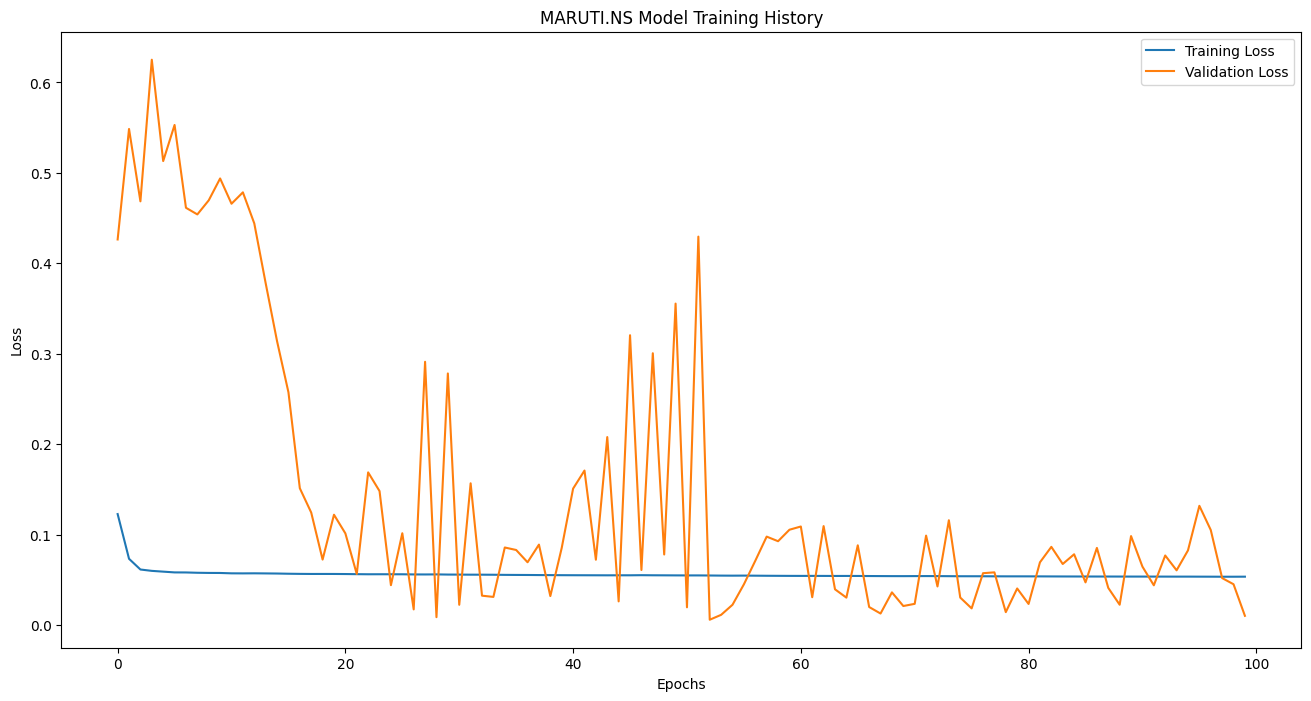

In [26]:
# Plot training History (Loss Curve)
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
from scipy.signal import argrelextrema

def predict_future(model, last_sequence, scaler, n_steps=1):
    last_sequence_reshaped = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))
    future_predictions = []
    current_input = last_sequence_reshaped
    for _ in range(n_steps):
        predicted_price = model.predict(current_input)[0, 0]
        future_predictions.append(predicted_price)
        # Update input sequence by adding the predicted price
        current_input = np.roll(current_input, -1, axis=1)
        current_input[0, -1, 0] = predicted_price
        # Optionally, keep other features (sentiment, etc.) at their last value
        if current_input.shape[2] > 1:
            current_input[0, -1, 1:] = current_input[0, -2, 1:]
    # Use correct number of columns for inverse_transform
    n_features = scaler.n_features_in_ if hasattr(scaler, "n_features_in_") else df.shape[1]
    future_predictions = scaler.inverse_transform(
        np.hstack((np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), n_features - 1))))
    )[:, 0]
    return future_predictions

def find_optimal_buy_points(prices, window=3, threshold=0.01):
    buy_indices = []
    buy_signals = {"points": [], "reasons": []}
    if len(prices) < 2*window+1:
        return buy_indices, buy_signals
    for i in range(window, len(prices)-window):
        window_slice = prices[i-window:i+window+1]
        if prices[i] == min(window_slice):
            before_diff = prices[i] - min(prices[i-window:i])
            after_diff = prices[i] - min(prices[i+1:i+window+1])
            if before_diff > threshold and after_diff > threshold:
                buy_indices.append(i)
                buy_signals["points"].append(prices[i])
                buy_signals["reasons"].append("Local minimum with significant change before and after")
    if not buy_indices and len(prices) > 0:
        min_idx = np.argmin(prices)
        buy_indices.append(min_idx)
        buy_signals["points"].append(prices[min_idx])
        buy_signals["reasons"].append("Lowest price point")
    return buy_indices, buy_signals

def plot_with_future_predictions(train, valid, model, X_test, scaler, user_input_date):
    if user_input_date:
        try:
            future_start_date = datetime.strptime(user_input_date, '%Y-%m-%d')
        except ValueError:
            raise ValueError("Invalid date format. Please use 'YYYY-MM-DD'.")
    else:
        future_start_date = datetime.today()
    last_sequence = X_test[-1]
    last_date = valid.index[-1]
    future_days = (future_start_date - last_date).days
    if future_days <= 0:
        raise ValueError("The prediction date must be in the future. Please provide a valid future date.")
    future_prices = predict_future(model, last_sequence, scaler, n_steps=future_days)
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_days, freq='B')
    buy_indices, buy_signals = find_optimal_buy_points(future_prices)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['Close'], 
                             mode='lines', name='Train Data',
                             fill='tozeroy',
                             fillgradient=dict(type='vertical',
                                               colorscale=[[0, 'rgba(74,143,223,0.1)'],
                                                           [1, 'rgba(76,148,223,0.8)']]),
                             line=dict(color='rgba(74,143,223,255)')))
    fig.add_trace(go.Scatter(x=valid.index, y=valid['Close'], 
                             mode='lines', name='Actual Price',
                             fill='tozeroy',
                             fillgradient=dict(type='vertical',
                                               colorscale=[[0, 'rgba(0,255,0,0.1)'],
                                                           [1, 'rgba(0,255,0,0.8)']]), 
                             line=dict(color='green')))
    fig.add_trace(go.Scatter(x=valid.index, y=valid['Predictions'],
                             fill='tozeroy',
                             fillgradient=dict(type='vertical',
                                               colorscale=[[0, 'rgba(255,0,0,0.1)'],
                                                           [1, 'rgba(255,0,0,0.8)']]),
                             mode='lines', name='Predicted Price', 
                             line=dict(color='red')))
    fig.add_trace(go.Scatter(x=future_dates, y=future_prices,
                             fill='tozeroy',
                             fillgradient=dict(type='vertical',
                                               colorscale=[[0, 'rgba(255,165,0,0.1)'],
                                                           [1, 'rgba(255,165,0,0.8)']]),
                             mode='lines', name='Future Predictions', 
                             line=dict(color='orange', dash='dash')))
    fig.add_trace(go.Scatter(x=future_dates, y=future_prices,
                             mode='markers', name='Future Points',
                             marker=dict(color='orange', size=8)))
    if buy_indices:
        buy_dates = [future_dates[i] for i in buy_indices]
        buy_prices = [future_prices[i] for i in buy_indices]
        fig.add_trace(go.Scatter(x=buy_dates, y=buy_prices,
                                mode='markers', name='Buy Signals',
                                marker=dict(color='cyan', size=12, symbol='star', line=dict(width=2, color='black')),
                                hovertemplate='<b>Buy Signal</b><br>Date: %{x}<br>Price: ₹%{y:,.2f}<br>Reason: %{text}<extra></extra>',
                                text=buy_signals["reasons"]))
    fig.update_layout(title='Stock Price Prediction with Future Forecast & Buy Signals',
                      xaxis_title='Date',
                      yaxis_title='Stock Price',
                      width=900,
                      legend=dict(x=0, y=1),
                      plot_bgcolor='rgba(19,27,43,0.0)',
                      paper_bgcolor='rgba(19,27,43,0.0)',
                      font=dict(color='rgba(105,123,147,255)'),
                      hovermode="closest",
                      yaxis=dict(spikecolor="rgba(105,123,149,255)",
                                 spikedash="solid",
                                 spikethickness=-2,
                                 tickformat=',',
                                 tickprefix='₹',
                                 gridcolor="rgba(105,123,147,0.4)",
                                 zeroline=False),
                      xaxis=dict(spikecolor="rgba(105,123,147,255)",
                                 spikedash="solid",
                                 spikethickness=-2,
                                 gridcolor="rgba(105,123,147,0.4)",
                                 ))
    fig.update_xaxes(showline=False, linewidth=0, linecolor='rgba(105,123,147,255)')
    for i, idx in enumerate(buy_indices):
        fig.add_annotation(
            x=future_dates[idx],
            y=future_prices[idx],
            text="BUY",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="cyan",
            ax=0,
            ay=-40,
            font=dict(size=12, color="cyan"),
            bordercolor="black",
            borderwidth=1,
            borderpad=4,
            bgcolor="rgba(0,0,0,0.6)",
            opacity=0.8
        )
    fig.show()
    return future_dates, future_prices, buy_indices, buy_signals

In [ ]:
future_dates, future_prices, buy_indices, buy_signals = plot_with_future_predictions(
    train, valid, model, X_test, scaler, user_input_date=input("Enter a date in YYYY-MM-DD format at least 6 days from current date: ")
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


: 